In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''
Returns the sum of 2 vectors of not necesseraly the same length by appending 0's to the shorter vector.
'''
def sum_two_vec_pad(a, b):
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c

'''
returns the energy for an estimated weight vector omega, with data (X, Y)
'''
def energy(w, X, Y):
    Y_est = np.sign(np.dot(X, w))
    return 0.5 * np.sum((Y - Y_est)**2)

def accept_prob(wp, w, beta, X, Y):
    return min(1, np.exp(-beta*(energy(wp, X, Y) - energy(w, X, Y))))

def accept_prob_with_energy(wp, w, beta, X, Y):
    next_energy = energy(wp, X, Y)
    return (min(1, np.exp(-beta*(next_energy - energy(w, X, Y)))), next_energy)

def accept_prob_with_energy_using_energy(wp, prev_energy, beta, X, Y):
    next_energy = energy(wp, X, Y)
    return (min(1.0, np.exp(-beta*(next_energy - prev_energy))), next_energy)

def overlap(wp, w):
    return 1.0 / (w.shape[0]) * np.dot(w, wp)

def delta_energy_fast(w, wp, idx, X, Y):
    Xw = np.dot(X, w)
    w_tmp = np.zeros(w.shape[0])
    w_tmp[idx] = wp[idx] - w[idx] 
    Xwp = Xw + np.dot(X, w_tmp)
    Y_est = np.sign(Xw)
    Y_estp = np.sign(Xwp)
    return 0.5 * np.sum((Y - Y_estp)**2),  0.5*np.sum((Y - Y_est)**2)

def accept_prob_fast(wp, w, beta, X, Y, idx):
    e_next, e = delta_energy_fast(w, wp, idx, X, Y)
    return min(1, np.exp(-beta*(e_next - e))), e_next

In [60]:
def metropolis_fastest(w_init, beta, beta_pace, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)

    energy_record = np.array([])
    current_energy = energy(w, X, Y)
    energy_record = np.append(energy_record, current_energy)
   
    while (current_energy > epsilon):
    
        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]
        
        accept_probability, next_energy = accept_prob_with_energy_using_energy(wp, current_energy, beta, X, Y)
        if np.random.uniform() < accept_probability:
            # accept the move, update the weights and the current energy
            w = wp 
            current_energy = next_energy
        
        energy_record= np.append(energy_record, current_energy)
        beta = beta * beta_pace
        
    return w, energy_record

def metropolis_mult_fastest(nb_runs, beta, beta_pace, N, M, epsilon=0):
    energy_record_acc = np.zeros(N)

    for k in range(0, nb_runs):
        w = 2 * np.random.random_integers(0, 1, N) - 1
        X = np.random.randn(M, N)
        Y = np.sign(np.dot(X, w))
        w_init =  2 * np.random.randint(0, 2, N) - 1
        _, energy_record = metropolis_fastest(w_init, beta, beta_pace, X, Y, epsilon)
        energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)
        

    return energy_record_acc / nb_runs

In [51]:
np.random.seed(2121)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


0.28


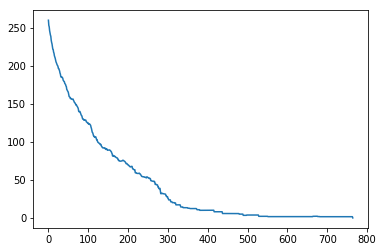

In [78]:
nb_runs = 20

# alpha and beta in [0.5, 5], for 'interesting' results as per paper.
N = 40
M = 250
beta = 0.3
beta_pace = 1.001

# Tests for part 1.
import timeit
start_time = timeit.default_timer()

part1_1 = metropolis_mult_fastest(nb_runs, beta, beta_pace, N, M, epsilon=0)
plt.plot(part1_1);
elapsed = timeit.default_timer() - start_time
print(round(elapsed, 2))

# Observations

With smaller N (e.g. N = 40), a higher pace is faster.
For beta_pace = 1.001, convergence will be quite fast for N = 40, but slow for N = 60

# Quadratic multiplicative cooling




In [70]:
def metropolis_quad_cooling(w_init, beta_init, lamb, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)

    energy_record = np.array([])
    current_energy = energy(w, X, Y)
    energy_record = np.append(energy_record, current_energy)
    
 
    k = 0
    while (current_energy > epsilon):
    
        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]
        
        accept_probability, next_energy = accept_prob_with_energy_using_energy(wp, current_energy, beta, X, Y)
        if np.random.uniform() < accept_probability:
            # accept the move, update the weights and the current energy
            w = wp 
            current_energy = next_energy
        
        energy_record= np.append(energy_record, current_energy)
        beta = beta_init * (1 + lamb*k*k)
        k += 1
        
    return w, energy_record

def metropolis_mult_quad_cooling(nb_runs, beta_init, lamb, N, M, epsilon=0):
    energy_record_acc = np.zeros(N)

    for k in range(0, nb_runs):
        w = 2 * np.random.random_integers(0, 1, N) - 1
        X = np.random.randn(M, N)
        Y = np.sign(np.dot(X, w))
        w_init =  2 * np.random.randint(0, 2, N) - 1
        _, energy_record = metropolis_fastest(w_init, beta_init, lamb, X, Y, epsilon)
        energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)
        

    return energy_record_acc / nb_runs

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


0.22


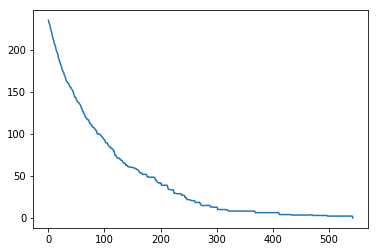

In [77]:
nb_runs = 20

# alpha and beta in [0.5, 5], for 'interesting' results as per paper.
N = 40
M = 250
beta_init = 0.8
lamb = 0.999

# Tests for part 1.
import timeit
start_time = timeit.default_timer()

part1_1 = metropolis_mult_quad_cooling(nb_runs, beta_init, lamb, N, M, epsilon=0)
plt.plot(part1_1);
elapsed = timeit.default_timer() - start_time
print(round(elapsed, 2))